# Problem and approach

The task is to formulate an operation strategy for a grid connected battery system, to perform energy arbitrage on the New York Independent System Operator (NYISO) day-ahead market. What is the NYISO? According to their [website](https://www.nyiso.com/what-we-do),
>The NYISO is the New York Independent System Operator — the organization responsible for managing New York’s electric grid and its competitive wholesale electric marketplace.

The NYISO makes the next day's hourly energy prices available at 11am each day (NYISO 2019, references available at bottom of page). The battery system we design here will schedule the next 24 hours of battery operation (noon of the current day through the 11am hour of the next day) using this information. We will assume that after the daily price announcement from the NYISO, the next 36 hours of price information are available: the prices for the remaining 12 hours of the current day, as well as 24 hours worth of prices for the next day. Therefore the optimization time horizon will be 36 hours, to take advantage of all available future price information.

Since the operational schedule will be repeated each day, the last 12 hours of the 36 hour strategy will always be ignored. This is because new price information will become available at 11am the following day, which we can take advantage of. However these "extra 12 hours" of data are not wasted; I determined in initial experiments that having a 36 hour time horizon creates a more profitable arbitrage strategy than shorter horizons. This makes intuitive sense, because the more future information we can incorporate into the arbitrage strategy, the more profitable it should be. You can experiment with different horizons using the code below, although the horizon is assumed to be at least 24 hours here. The plan can be visualized as follows:

![png](./images/Slide2_crop.png)

The battery is said to be a price taker, meaning its activities do not affect the price of energy. The price paid for power to charge the battery, and revenue from discharging, is the location based marginal price (LBMP), which takes in to account the system marginal price, congestion component, and marginal loss component (PJM Interconnection LLC). The goal is to maximize profit, given the day-ahead prices and the battery system's parameters.

In this scenario, where future prices are known and the battery system is a price taker, the problem of designing an operational strategy can be solved by linear programming (Salles et al. 2017, Sioshansi et al. 2009, Wang and Zhang 2018). In brief summary, [linear programming](https://en.wikipedia.org/wiki/Linear_programming) is a well-known technique for either maximizing or minimizing some objective. In this case, we want to maximize profit. As long as the mathematical function describing the objective, known as the __objective function__, as well as the __constraints__ of the system, can all be described as linear combinations of the __decision variables__, which define the operational strategy, linear programming can be used to optimize the system.

## Setting up the linear programming problem in PuLP

Loosely following the notation of Sioshansi et al. (2009), here we'll lay out the decision variables and add the contraints to a linear programming model in PuLP. The markdown code snippets in this section all get put together to define a class at the end of the section, which describes our battery system. This model of the system will be useful to simulate battery operation, stepping through time at a daily increment.

Before proceeding further let's import the packages needed for this exercise.

In [97]:
#Load packages
import pulp
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
%matplotlib inline 

Each day, a single optimization problem needs to be solved between 11am and 12pm, which will provide sufficient information to guide the battery's operation for the next 36 hours. To guide the battery's operation, we need to decide what the flow of energy will be for each discrete time step in the time horizon. Energy flows, also known as electrical power, can either be into or out of the battery. So we'll create two decision variables, $c_t$ and $d_t$, as the charging and discharging power flows, respectively (kW), at time $t$, which will be an hourly time step. The rates of charge or discharge are continuous variables and are bounded to be within the operating limits of the battery, for all time steps:

$$ 0 \le c_t, d_t \le \kappa, \forall t $$

where $\kappa$ (kW) is the maximum charge and discharge power capacity, which we'll assume are equal here. 

We need to specify flow variables for each time step in the time horizon of optimization. PuLP provides a handy method `dicts` of the `LpVariable` class, which we can use to create charge and discharge flows for all time steps at once. We'll start defining a class that will hold all the information governing the operation of the battery. The input `time_horizon` is an integer specifiying the number of hours in the optimization horizon, assumed here to be at least 24, and the other inputs are as described above:

```python
class Battery():
    
    def __init__(self,
                 time_horizon,
                 max_discharge_power_capacity,
                 max_charge_power_capacity):
        #Set up decision variables for optimization.
        #These are the hourly charge and discharge flows for
        #the optimization horizon, with their limitations.
        self.time_horizon = time_horizon
    
        self.charge = \
        pulp.LpVariable.dicts(
            "charging_power",
            ('c_t_' + str(i) for i in range(0,time_horizon)),
            lowBound=0, upBound=max_charge_power_capacity,
            cat='Continuous')

        self.discharge = \
        pulp.LpVariable.dicts(
            "discharging_power",
            ('d_t_' + str(i) for i in range(0,time_horizon)),
            lowBound=0, upBound=max_discharge_power_capacity,
            cat='Continuous')
```

After setting up all the decision variables, it's time to define the optimization problem that PuLP will solve for us. Our goal is to maximize profit $P$ within the optimization time horizon, which can be defined as follows using charge flows and the price of energy:

$$ P \left( d_t, c_t, p_t \right) = \frac{ \sum_{t=12\text{pm of current day}}^{11\text{pm of next day}} p_t \cdot (d_t - c_t) }{1000}$$

where $p_t$ is the LBMP (\\$/MWh) at time $t$. In terms of units, because $t$ is an hourly time step, it effectively cancels the per hour part of the units of the LBMP. The objective function is divided by 1000 to account for the discrepancy in units (MW/kW), so ultimately the objective of profit will be in units of dollars. We'll make this unit correction after running the simulation, so it won't be reflected in the code here.

The objective function is specified by adding the decision variables to the model object in PuLP, multiplying each by the appropriate cost or revenue that would come from charging or discharging that amount of energy. This multiplication of decision variables by prices is accomplished using an `LpAffineExpression`. The `prices` are determined by the LBMP, which we'll select for the relevant time period when we run the simulation. For example, with a 36 hour time horizon, this would be noon the current day, through the 11pm hour the next day.

```python
    def set_objective(self, prices):
        #Create a model and objective function.
        #This uses price data, which must have one price
        #for each point in the time horizon.
        try:
            assert len(prices) == self.time_horizon
        except:
            print('Error: need one price for each hour in time horizon')
        
        #Instantiate linear programming model to maximize the objective
        self.model = pulp.LpProblem("Energy arbitrage", pulp.LpMaximize)
    
        #Objective is profit
        #This formula gives the daily profit from charging/discharging
        #activities. Charging is a cost, discharging is a revenue
        self.model += \
        pulp.LpAffineExpression(
            [(self.charge['c_t_' + str(i)],
              -1*prices[i]) for i in range(0,self.time_horizon)]) +\
        pulp.LpAffineExpression(
            [(self.discharge['d_t_' + str(i)],
              prices[i]) for i in range(0,self.time_horizon)])
```

Having defined the model and the objective, now we need to add the battery's operational constraints. The battery has limited capacity and so the optimization is subject to battery storage constraints:

$$ 0 <= \sum_{t=12\text{pm of current day}}^{t_f} s_{i} + \eta \cdot
c_t - d_t <= \text{discharge energy capacity (kWh)}$$

where $t_f$ = each hour from 1pm on the current day through 11pm the next day, $s_i$ is the state of energy (kWh) of the battery at the start of the 36-hour optimization period and $\eta$ is the round-trip efficiency of the battery. This constraint requires the battery's state of energy (sum of initial state and hourly power flows) to be between zero, assuming the battery has complete depth of discharge capabilities, and the battery's discharge energy capacity, for each hour of the optimization horizon. In this constraint, the power flows (kW) are understood to be converted to units of energy (kWh) through multiplication by the one hour time step.

In PuLP, constraints can be added to a model just like the objective function: using addition syntax. We can express these constraints by adding up the discharge flows using `lpSum`, and in the case of charge flows which need to be multiplied by efficiency, again an `LpAffineExpression`.

Maximum daily discharged throughput $\tau$ (kWh) is also constrained, which limits the amount of energy that can flow through the battery in a given day. We set this up so that the first day of the time horizon is subject to a 24 hour constraint, and whatever portion beyond that is subject to a fractional constraint. For example, in our 36 hour horizon, the constraints would be:

$$ \sum_{t=12\text{pm of current day}}^{11\text{am of next day}} d_t <= \tau$$

and

$$ \sum_{t=12\text{pm of next day}}^{11\text{pm of next day}} d_t <= 0.5 \cdot \tau$$


Now that we've set up the model with an objective function and all constraints, we include methods to solve the problem, and report back the results, which are the optimal charge and discharge flows for each hour in the time horizon. As long as the problem we set up is feasible in terms of the constraints we've indicated, linear programming should work in that it will find an optimal solution, that maximizes profit. However if not, we will return a message indicating this.

In [98]:
class Battery():
    
    def __init__(self,
                 time_horizon,
                 max_discharge_power_capacity,
                 max_charge_power_capacity):
        #Set up decision variables for optimization.
        #These are the hourly charge and discharge flows for
        #the optimization horizon, with their limitations.
        self.time_horizon = time_horizon
    
        self.charge = \
        pulp.LpVariable.dicts(
            "charging_power",
            ('c_t_' + str(i) for i in range(0,time_horizon)),
            lowBound=0, upBound=max_charge_power_capacity,
            cat='Continuous')

        self.discharge = \
        pulp.LpVariable.dicts(
            "discharging_power",
            ('d_t_' + str(i) for i in range(0,time_horizon)),
            lowBound=0, upBound=max_discharge_power_capacity,
            cat='Continuous')

    def set_objective(self, prices):
        #Create a model and objective function.
        #This uses price data, which must have one price
        #for each point in the time horizon.
        try:
            assert len(prices) == self.time_horizon
        except:
            print('Error: need one price for each hour in time horizon')
        
        #Instantiate linear programming model to maximize the objective
        self.model = pulp.LpProblem("Energy arbitrage", pulp.LpMaximize)
    
        #Objective is profit
        #This formula gives the daily profit from charging/discharging
        #activities. Charging is a cost, discharging is a revenue
        self.model += \
        pulp.LpAffineExpression(
            [(self.charge['c_t_' + str(i)],
              -1*prices[i]) for i in range(0,self.time_horizon)]) +\
        pulp.LpAffineExpression(
            [(self.discharge['d_t_' + str(i)],
              prices[i]) for i in range(0,self.time_horizon)])
        
    def add_storage_constraints(self,
                                efficiency,
                                depth_of_discharge,
                                battery_capacity,
                                initial_level):
        #Storage level constraint 1
        #This says the battery cannot have less than zero energy, at
        #any hour in the horizon
        #Note this is a place where round-trip efficiency is factored in.
        #The energy available for discharge is the round-trip efficiency
        #times the energy that was charged.       
        for hour_of_sim in range(1,self.time_horizon+1):     
            self.model += \
            initial_level \
            + pulp.LpAffineExpression(
                [(self.charge['c_t_' + str(i)], efficiency)
                 for i in range(0,hour_of_sim)]) \
            - pulp.lpSum(
                self.discharge[index]
                for index in('d_t_' + str(i)
                             for i in range(0,hour_of_sim)))\
            >= depth_of_discharge*battery_capacity
            
        #Storage level constraint 2
        #Similar to 1
        #This says the battery cannot have more than the
        #discharge energy capacity
        for hour_of_sim in range(1,self.time_horizon+1):
            self.model += \
            initial_level \
            + pulp.LpAffineExpression(
                [(self.charge['c_t_' + str(i)], efficiency)
                 for i in range(0,hour_of_sim)]) \
            - pulp.lpSum(
                self.discharge[index]
                for index in ('d_t_' + str(i)
                              for i in range(0,hour_of_sim)))\
            <= battery_capacity
            
    def add_throughput_constraints(self,
                                   max_daily_discharged_throughput):
        #Maximum discharge throughput constraint
        #The sum of all discharge flow within a day cannot exceed this
        #can associate a cost to discharge to simulate degradation
        #Include portion of the next day according to time horizon
        #Assumes the time horizon is at least 24 hours
        
        self.model += \
        pulp.lpSum(
            self.discharge[index] for index in (
                'd_t_' + str(i) for i in range(0,24))) \
        <= max_daily_discharged_throughput
        
        self.model += \
        pulp.lpSum(
            self.discharge[index] for index in (
                'd_t_' + str(i) for i in range(25,self.time_horizon))) \
        <= max_daily_discharged_throughput \
        *float(self.time_horizon-24)/24
        
    def solve_model(self):
        #Solve the optimization problem
        self.model.solve()
        
        #Show a warning if an optimal solution was not found
        if pulp.LpStatus[self.model.status] != 'Optimal':
            print('Warning: ' + pulp.LpStatus[self.model.status])
            
    def collect_output(self):  
        #Collect hourly charging and discharging rates within the
        #time horizon
        hourly_charges =\
            np.array(
                [self.charge[index].varValue for
                 index in ('c_t_' + str(i) for i in range(0,24))])
        hourly_discharges =\
            np.array(
                [self.discharge[index].varValue for
                 index in ('d_t_' + str(i) for i in range(0,24))])

        return hourly_charges, hourly_discharges

# Import price data
We obtain one year's worth of LBMPs, so we can simulate the battery's operation over this period of time. The data is available as LBMPs for several zones, at an hourly time step. Here we load the CSV files (one per day) and concatenate them on to a `DataFrame`. You can obtain these data from the [git repo](https://github.com/klostest/energy_arbitrage_work_sample) accompanying this blog post. The data were downloaded from [here](http://mis.nyiso.com/public/) on May 2, 2020, as zipped directories of CSV files (Pricing Data, Day-Ahead Market (DAM) LBMP, Zonal P-2A).

In [99]:
#Directory of data
data_dir = './data_2019_2020_from_web/'

In [100]:
dir_list = os.listdir(data_dir)
dir_list.sort()
dir_list

['20190501damlbmp_zone_csv',
 '20190601damlbmp_zone_csv',
 '20190701damlbmp_zone_csv',
 '20190801damlbmp_zone_csv',
 '20190901damlbmp_zone_csv',
 '20191001damlbmp_zone_csv',
 '20191101damlbmp_zone_csv',
 '20191201damlbmp_zone_csv',
 '20200101damlbmp_zone_csv',
 '20200201damlbmp_zone_csv',
 '20200301damlbmp_zone_csv',
 '20200401damlbmp_zone_csv']

In [101]:
#Remove invisible files (i.e. .DS_Store used by Mac OS)
for this_item in dir_list:
    if this_item[0] == '.':
        dir_list.remove(this_item)

Loop through all the subdirectories, loading all the CSV files.

In [102]:
tic = time.time()
#count loaded files
file_counter = 0

#For each subdirectory in the parent directory
for this_sub_dir in dir_list:
    #List the files
    this_sub_dir_list = os.listdir(data_dir + '/' + this_sub_dir)
    #Sort the list
    this_sub_dir_list.sort()
    #Delete invisible files (that start with '.')
    for this_item in this_sub_dir_list:
        if this_item[0] == '.':
            this_sub_dir_list.remove(this_item)
    #For each file in the subdirectory
    for this_file in this_sub_dir_list:
        #Load the contents into a DataFrame
        this_df = pd.read_csv(data_dir + '/' + this_sub_dir + '/' + this_file)
        #Concatenate with existing data if past first file
        if file_counter == 0:
            all_data = this_df.copy()
        else:
            all_data = pd.concat([all_data, this_df])
        
        file_counter += 1
toc = time.time()
print(str(toc-tic) + ' seconds run time')

0.8151872158050537 seconds run time


Examine the data

In [103]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131760 entries, 0 to 359
Data columns (total 6 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Time Stamp                         131760 non-null  object 
 1   Name                               131760 non-null  object 
 2   PTID                               131760 non-null  int64  
 3   LBMP ($/MWHr)                      131760 non-null  float64
 4   Marginal Cost Losses ($/MWHr)      131760 non-null  float64
 5   Marginal Cost Congestion ($/MWHr)  131760 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 7.0+ MB


In [104]:
all_data.head()

,Time Stamp,Name,PTID,LBMP ($/MWHr),Marginal Cost Losses ($/MWHr),Marginal Cost Congestion ($/MWHr)
0,05/01/2019 00:00,CAPITL,61757,20.43,0.93,-4.04
1,05/01/2019 00:00,CENTRL,61754,16.17,0.15,-0.55
2,05/01/2019 00:00,DUNWOD,61760,20.13,1.50,-3.17
3,05/01/2019 00:00,GENESE,61753,15.62,-0.26,-0.43
4,05/01/2019 00:00,H Q,61844,15.09,-0.37,0.00


Sanity checks on data. Considering we have 12 months of data including a February 29th from a leap year, were 366 days of data loaded?

In [105]:
assert file_counter == 366

How many zones are there, and what are they?

In [106]:
unique_names = all_data['Name'].unique()
print(len(unique_names))
unique_names

15


array(['CAPITL', 'CENTRL', 'DUNWOD', 'GENESE', 'H Q', 'HUD VL', 'LONGIL',
       'MHK VL', 'MILLWD', 'N.Y.C.', 'NORTH', 'NPX', 'O H', 'PJM', 'WEST'],
      dtype=object)

How may rows are there?

In [107]:
all_data.shape

(131760, 6)

Check that number of rows = number of zones times 24 hours a day times 366 days a year:

In [108]:
assert 15*24*366 == all_data.shape[0]

For this example we'll concern ourselves only with New York City. Select out the data of interest (specific zone):

In [109]:
zone_of_interest = 'N.Y.C.'
all_data = all_data.loc[all_data['Name'].isin([zone_of_interest]),:]

In [110]:
all_data.shape

(8784, 6)

The `DataFrame` will be easier to use with a `DatetimeIndex`.
Reset the index to the time stamp:

In [111]:
all_data = all_data.set_index(['Time Stamp'])

Cast as `datetime`:

In [112]:
all_data.index = pd.to_datetime(all_data.index, format='%m/%d/%Y %H:%M')

Let's examine how the data look around the daylight savings transition:

In [113]:
start_time = pd.Timestamp(year=2019, month=11, day=2, hour=23)
end_time = pd.Timestamp(year=2019, month=11, day=3, hour=3)

In [114]:
time_test_1 = all_data[start_time:end_time]
time_test_1

,Name,PTID,LBMP ($/MWHr),Marginal Cost Losses ($/MWHr),Marginal Cost Congestion ($/MWHr)
Time Stamp,,,,,
2019-11-02 23:00:00,N.Y.C.,61761,18.17,1.15,-5.74
2019-11-03 00:00:00,N.Y.C.,61761,19.03,1.09,-6.85
2019-11-03 01:00:00,N.Y.C.,61761,17.44,0.99,-6.21
2019-11-03 01:00:00,N.Y.C.,61761,17.35,1.02,-5.72
2019-11-03 02:00:00,N.Y.C.,61761,16.64,0.87,-6.45
2019-11-03 03:00:00,N.Y.C.,61761,16.23,0.93,-5.70


We can see that there are two entries for 1am, where the second one was a result of the clocks being "turned back". In order to do arithmetic with this `DatetimeIndex`, we need to make it timezone-aware. Pandas makes this easy and handles the duplicate 1am row appropriately:

In [115]:
all_data.index = \
all_data.index.tz_localize('America/New_York', ambiguous='infer')

In [116]:
time_test_2 = all_data[start_time:end_time]
time_test_2

c:\Users\liams\anaconda3\envs\Energy_env\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  """Entry point for launching an IPython kernel.


,Name,PTID,LBMP ($/MWHr),Marginal Cost Losses ($/MWHr),Marginal Cost Congestion ($/MWHr)
Time Stamp,,,,,
2019-11-02 23:00:00-04:00,N.Y.C.,61761,18.17,1.15,-5.74
2019-11-03 00:00:00-04:00,N.Y.C.,61761,19.03,1.09,-6.85
2019-11-03 01:00:00-04:00,N.Y.C.,61761,17.44,0.99,-6.21
2019-11-03 01:00:00-05:00,N.Y.C.,61761,17.35,1.02,-5.72
2019-11-03 02:00:00-05:00,N.Y.C.,61761,16.64,0.87,-6.45
2019-11-03 03:00:00-05:00,N.Y.C.,61761,16.23,0.93,-5.70


Now we can see that the offset from UTC is indicated. Let's double check the beginning and end of our data before proceeding.

In [117]:
all_data.head()

,Name,PTID,LBMP ($/MWHr),Marginal Cost Losses ($/MWHr),Marginal Cost Congestion ($/MWHr)
Time Stamp,,,,,
2019-05-01 00:00:00-04:00,N.Y.C.,61761,20.32,1.69,-3.18
2019-05-01 01:00:00-04:00,N.Y.C.,61761,17.09,1.62,-0.06
2019-05-01 02:00:00-04:00,N.Y.C.,61761,14.89,1.37,-0.05
2019-05-01 03:00:00-04:00,N.Y.C.,61761,14.49,1.29,0.00
2019-05-01 04:00:00-04:00,N.Y.C.,61761,14.49,1.27,0.00


In [118]:
all_data.tail()

,Name,PTID,LBMP ($/MWHr),Marginal Cost Losses ($/MWHr),Marginal Cost Congestion ($/MWHr)
Time Stamp,,,,,
2020-04-30 19:00:00-04:00,N.Y.C.,61761,18.92,1.49,-4.15
2020-04-30 20:00:00-04:00,N.Y.C.,61761,20.91,1.52,-5.60
2020-04-30 21:00:00-04:00,N.Y.C.,61761,18.08,1.48,-3.36
2020-04-30 22:00:00-04:00,N.Y.C.,61761,16.36,1.45,-1.75
2020-04-30 23:00:00-04:00,N.Y.C.,61761,16.17,1.35,-1.72


Looks like the data span the year in time from May 1, 2019 through the end of April 2020, as intended.

# Run the simulation
In this section, we'll define a function, `simulate_battery`, that simulates the operation of the battery for energy arbitrage over the course of a year. Here are the inputs to the function:

- `initial_level`, the initial level of battery charge at start of simulation (kWh)
- `price_data`, the `DataFrame` with the hourly LBMP (\\$/MWh)
- `max_discharge_power_capacity`, $\kappa$ (kW)
- `max_charge_power_capacity`, also $\kappa$ (kW)
- `discharge_energy_capacity` (kWh)
- `efficiency`, the AC-AC Round-trip efficiency, $\eta$ (unitless)
- `max_daily_discharged_throughput`, $\tau$ (kWh)
- `time_horizon`, the optimization time horizon (h), assumed here to be greater than or equal to 24.
- `start_day`, a pandas `Timestamp` for noon on the first simulation day

The function returns several outputs that can be used to examine system operation:

- `all_hourly_charges`, `all_hourly_discharges`, `all_hourly_state_of_energy`, charging and discharging activity, and state of energy, at an hourly time step (kWh)
- `all_daily_discharge_throughput`, discharged throughput at a daily time step (kWh)

In [119]:
def simulate_battery(initial_level,
                     price_data,
                     max_discharge_power_capacity,
                     max_charge_power_capacity,
                     discharge_energy_capacity,
                     efficiency,
                     max_daily_discharged_throughput,
                     time_horizon,
                     start_day):
    #Track simulation time
    tic = time.time()
    
    #Initialize output variables
    all_hourly_charges = np.empty(0)
    all_hourly_discharges = np.empty(0)
    all_hourly_state_of_energy = np.empty(0)
    all_daily_discharge_throughput = np.empty(0)
    
    #Set up decision variables for optimization by
    #instantiating the Battery class
    battery = Battery(
        time_horizon=time_horizon,
        max_discharge_power_capacity=max_discharge_power_capacity,
        max_charge_power_capacity=max_charge_power_capacity)
    
    #############################################
    #Run the optimization for each day of the year.
    #############################################
    
    #There are 365 24-hour periods (noon to noon) in the simulation,
    #contained within 366 days
    for day_count in range(365):
        #print('Trying day {}'.format(day_count))
        
        #############################################
        ### Select data and simulate daily operation
        #############################################
        
        #Set up the 36 hour optimization horizon for this day by
        #adding to the first day/time of the simulation
        start_time = start_day \
        + pd.Timedelta(day_count, unit='days')
        end_time = start_time + pd.Timedelta(time_horizon-1, unit='hours')
        #print(start_time, end_time)
    
        #Retrieve the price data that will be used to calculate the
        #objective
        prices = \
        price_data[start_time:end_time]['LBMP ($/MWHr)'].values
                      
        #Create model and objective
        battery.set_objective(prices)

        #Set storage constraints
        battery.add_storage_constraints(
            efficiency=efficiency,
            depth_of_discharge=depth_of_discharge,
            battery_capacity=battery_capacity,
            initial_level=initial_level)
            
        #Set maximum discharge throughput constraint
        battery.add_throughput_constraints(
            max_daily_discharged_throughput=
            max_daily_discharged_throughput)

        #Solve the optimization problem and collect output
        battery.solve_model()
        hourly_charges, hourly_discharges = battery.collect_output()
        
        #############################################
        ### Manipulate daily output for data analysis
        #############################################
        
        #Collect daily discharge throughput
        daily_discharge_throughput = sum(hourly_discharges)
        #Calculate net hourly power flow (kW), needed for state of energy.
        #Charging needs to factor in efficiency, as not all charged power
        #is available for discharge.
        net_hourly_activity = (hourly_charges*efficiency) \
        - hourly_discharges
        #Cumulative changes in energy over time (kWh) from some baseline
        cumulative_hourly_activity = np.cumsum(net_hourly_activity)
        #Add the baseline for hourly state of energy during the next
        #time step (t2)
        state_of_energy_from_t2 = initial_level \
        + cumulative_hourly_activity
        
        #Append output
        all_hourly_charges = np.append(all_hourly_charges, hourly_charges)
        all_hourly_discharges = np.append(
            all_hourly_discharges, hourly_discharges)
        all_hourly_state_of_energy = \
        np.append(all_hourly_state_of_energy, state_of_energy_from_t2)
        all_daily_discharge_throughput = \
        np.append(
            all_daily_discharge_throughput, daily_discharge_throughput)
        
        #############################################
        ### Set up the next day
        #############################################
        
        #Initial level for next period is the end point of current period
        initial_level = state_of_energy_from_t2[-1]
        
        

    toc = time.time()
        
    print('Total simulation time: ' + str(toc-tic) + ' seconds')

    return all_hourly_charges, all_hourly_discharges, \
        all_hourly_state_of_energy,\
        all_daily_discharge_throughput

Now we'll run our simulation through the year, using the following illustrative values for the battery's parameters.

In [195]:
battery_capacity = 80 #(kWh)
depth_of_discharge = 0.01 #unitless
discharge_energy_capacity = 100 #(kWh)
max_discharge_power_capacity = 80 #(kW)
max_charge_power_capacity = 80 #(kW)
efficiency = 0.91 #unitless
max_daily_discharged_throughput = 400  #(kWh)

To kick things off, we'll assume the battery is 75% charged to start.

In [196]:
initial_level = 0.75*battery_capacity
initial_level

60.0

In [197]:
all_hourly_charges, all_hourly_discharges, all_hourly_state_of_energy,\
all_daily_discharge_throughput = \
simulate_battery(initial_level=initial_level,
                 price_data=all_data,
                 max_discharge_power_capacity
                     =max_discharge_power_capacity,
                 max_charge_power_capacity
                     =max_charge_power_capacity,
                 discharge_energy_capacity=discharge_energy_capacity,
                 efficiency=efficiency,
                 max_daily_discharged_throughput
                     =max_daily_discharged_throughput,
                 time_horizon=36,
                 start_day=pd.Timestamp(
                     year=2019, month=5, day=1, hour=12,
                     tz='America/New_York'))

Total simulation time: 13.785680532455444 seconds


Sanity check: the number of simulated hours should be:

In [198]:
assert 24*365 == len(all_hourly_discharges)

# Analyze battery operation
Now we'll look at a suite of indicators of how the battery operated. We can check that all the constraints were satisfied, and analyze the financial impact of our system.

## Power output
Define power output with discharging as positive and charging as negative.

In [199]:
mpl.rcParams["figure.figsize"] = [5,3]
mpl.rcParams["figure.dpi"] = 100
mpl.rcParams.update({"font.size":12})

Text(0.5, 1.0, 'Hourly power output')

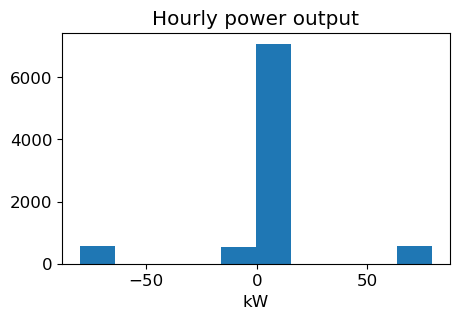

In [200]:
plt.hist(all_hourly_discharges - all_hourly_charges)
plt.xlabel('kW')
plt.title('Hourly power output')

This indicates that for most hours over the year, the power is close to zero. In other words, the battery is neither charging nor discharging. However it is also common for the battery to be operating at the limits of its range [-100, 100] kW.

## State of energy
The battery state of energy should be no less than zero, and no greater than the discharge energy capcacity, at any time: [0, 200] kWh.

Text(0.5, 1.0, 'Hourly state of energy')

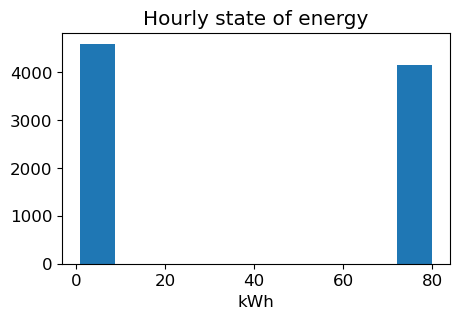

In [201]:
plt.hist(all_hourly_state_of_energy)
plt.xlabel('kWh')
plt.title('Hourly state of energy')

Results indicate the battery is operating within the prescribed limits of state of energy.

## Revenue, cost, and profit

We'll analyze the following financial indicators:
- Total annual revenue generation (\$)
- Total annual charging cost (\$)

We'll also look at the total annual discharged throughput (kWh) later. To examine all of these, it is convenient to put the data in a `DataFrame`.

Select out a new `DataFrame` based on the time frame of simulation, to report further results:

In [202]:
all_data_sim_time = all_data[
    pd.Timestamp(year=2019, month=5, day=1, hour=12, tz='America/New_York'):
    pd.Timestamp(year=2020, month=4, day=30, hour=11, tz='America/New_York')].copy()

Check there is the right number of rows:

In [203]:
all_data_sim_time.shape

(8760, 5)

In [204]:
assert all_data_sim_time.shape[0] == len(all_hourly_discharges)

Attach simulation results

In [205]:
#These indicate flows during the hour of the datetime index
all_data_sim_time['Charging power (kW)'] = all_hourly_charges
all_data_sim_time['Discharging power (kW)'] = all_hourly_discharges
all_data_sim_time['Power output (kW)'] = \
    all_hourly_discharges - all_hourly_charges
#This is the state of power at the beginning of the hour of the datetime index 
all_data_sim_time['State of Energy (kWh)'] = \
    np.append(initial_level, all_hourly_state_of_energy[0:-1])

Revenue and cost would be in units of
$\frac{\text{kW} \cdot \text{\$} \cdot \text{h}}{\text{MWh}} = 1000 \cdot \$$ , so divide by 1000 to adjust to $:

In [206]:
all_data_sim_time['Revenue generation ($)'] = \
all_data_sim_time['Discharging power (kW)'] \
* all_data_sim_time['LBMP ($/MWHr)'] / 1000

In [207]:
all_data_sim_time['Charging cost ($)'] = \
all_data_sim_time['Charging power (kW)'] \
* all_data_sim_time['LBMP ($/MWHr)'] / 1000

In [208]:
all_data_sim_time['Profit ($)'] = all_data_sim_time['Revenue generation ($)'] \
- all_data_sim_time['Charging cost ($)']

What is the total annual revenue generation?

In [209]:
all_data_sim_time['Revenue generation ($)'].sum()

1383.9393839946224

Total annual charging cost?

In [210]:
all_data_sim_time['Charging cost ($)'].sum()

894.6905671252376

Calculate profit

In [211]:
Profit = all_data_sim_time['Profit ($)'].sum()

print('Annual Profit: $' + str(Profit))

Annual Profit: $489.2488168693849


## Total annual discharged throughput

How much energy has flowed through this battery during the course of the year? For some context here, the sum of daily discharged throughput is limited to 200 kWh/day. If the battery discharged its maximum possible energy every day during the 365 day simulation, the total discharge would be:

In [212]:
365*200
#kWh

73000

And in fact it is:

In [213]:
sum(all_daily_discharge_throughput)

45609.599999747166

This implies the system is hitting the maximum discharged throughput limit on most days. We can check this by doing a `value_counts()` on the `Series` of daily throughput.

In [214]:
pd.Series(all_daily_discharge_throughput.round(0)).value_counts()

79.0     174
158.0    134
152.0     31
231.0     13
238.0      9
225.0      3
73.0       1
dtype: int64

The battery operated at maximum throughput for all but one day.

## Find the most profitable week
Group the profit column by week and locate the maximum:

In [215]:
max_profit_week = (all_data_sim_time['Profit ($)'].resample('W').sum() == \
all_data_sim_time['Profit ($)'].resample('W').sum().max()).values

In [216]:
all_data_sim_time['Profit ($)'].resample('W').sum()[max_profit_week]

Time Stamp
2019-07-21 00:00:00-04:00    22.127704
Freq: W-SUN, Name: Profit ($), dtype: float64

A week in July was the most profitable for energy arbitrage. For this week, let's make a graph of hourly battery state of energy and hourly LBMP.

In [217]:
mpl.rcParams["figure.figsize"] = [8,6]
mpl.rcParams["figure.dpi"] = 150
mpl.rcParams.update({"font.size":14})

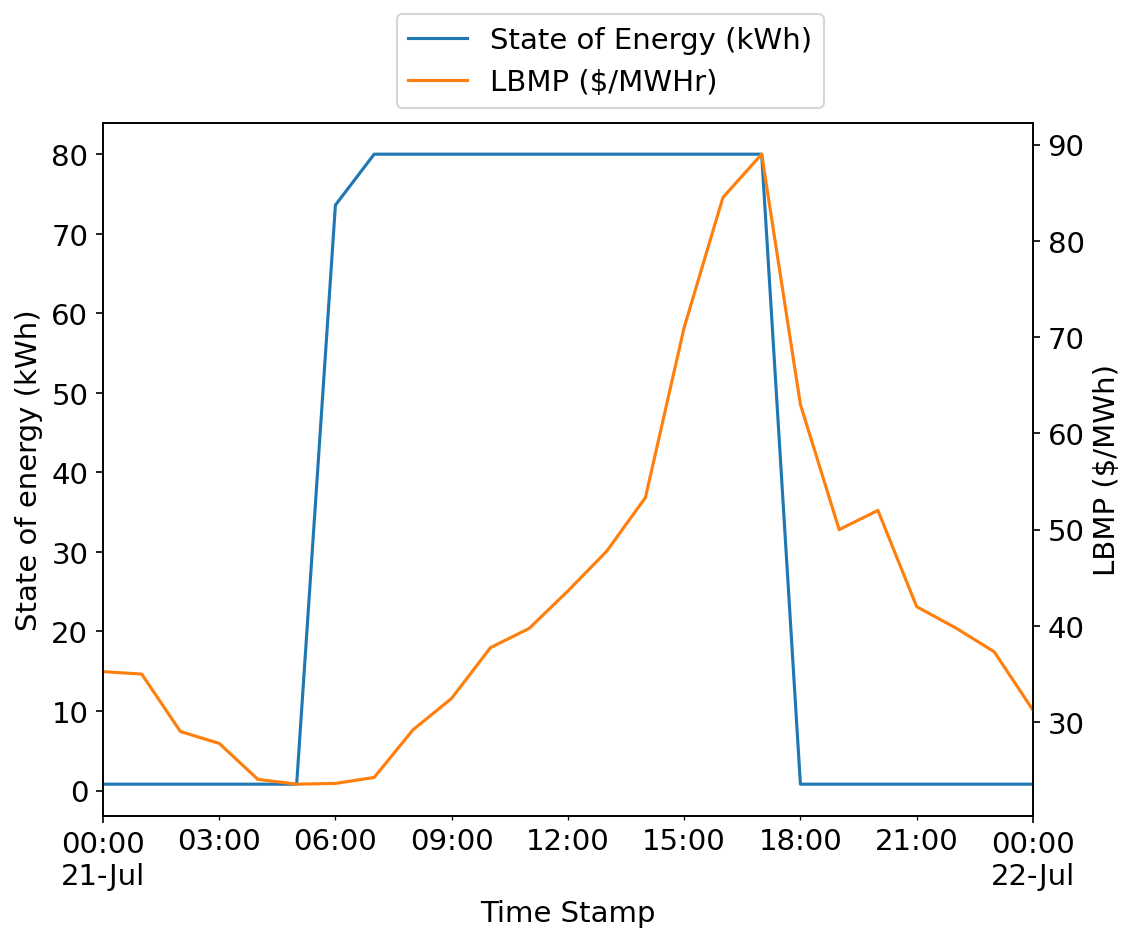

In [218]:
most_profit_week_start = pd.Timestamp(
    year=2019, month=7, day=21, tz='America/New_York')
ax = all_data_sim_time[
    most_profit_week_start:most_profit_week_start+pd.Timedelta(days=1)]\
[['State of Energy (kWh)', 'LBMP ($/MWHr)']]\
.plot(secondary_y='LBMP ($/MWHr)', mark_right=False)

ax.set_ylabel('State of energy (kWh)')
ax.right_ax.set_ylabel('LBMP ($/MWh)')
ax.xlim = (most_profit_week_start, most_profit_week_start+pd.Timedelta(days=1))
ax.get_legend().set_bbox_to_anchor((0.3, 1))

The battery appears to follow the general arbitrage strategy of "buy low, sell high", or in this case "charge cheaply, discharge discreetly" to take advantage of future price changes. It may be that during this week, it was quite warm in New York City, leading to high power demand for air conditioning, large price swings between day and night, and a good opportunity for our battery system to make some money.

## Monthly profit

In [219]:
mpl.rcParams["figure.figsize"] = [6,4]
mpl.rcParams["figure.dpi"] = 100
mpl.rcParams.update({"font.size":12})

Text(0, 0.5, 'Total monthly profit ($)')

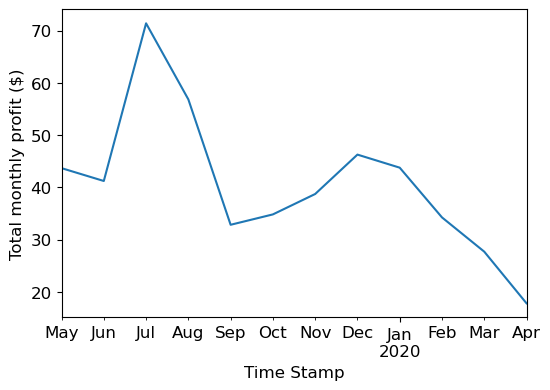

In [220]:
all_data_sim_time['Profit ($)'].resample('M').sum().plot()
plt.ylabel('Total monthly profit ($)')

Profit is mostly higher in the summer than winter, but is also high in January and December. A plot of the LBMP throughout the year sheds some light on this:

Text(0, 0.5, 'LBMP ($/MWHr)')

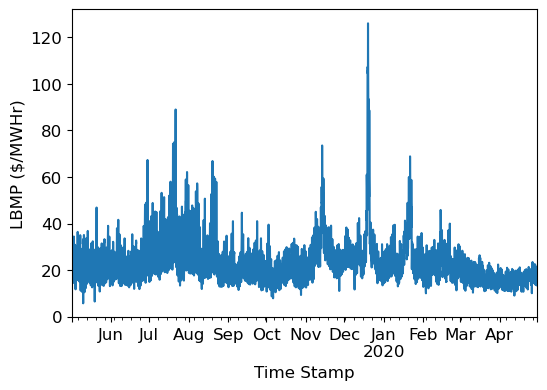

In [221]:
all_data_sim_time['LBMP ($/MWHr)'].plot()
plt.ylabel('LBMP ($/MWHr)')

Changes in price enable the arbitrage strategy to make profit. Generally, most of the larger price swings are during the summer months, probably reflecting increased demand due to air conditioning usage on hot summer days. But there are large price changes in November, December, and January. This may be due to tourism in New York City during the holiday season, or cold weather that increases demand for electricity for heating.

# Conclusions

We found that an energy arbitrage strategy for a grid-connected battery can be formulated using linear programming, assuming future prices are known over some time horizon. We showed that when operating under an illustrative set of system parameters and using real-world energy price data, such a system can generate an annual profit of \\$963.

Further optimization for increased profit may be possible, if prices are able to be accurately predicted beyond the 36 hour optimization horizon used here. The NYISO price determination involves a load forecasting model, that depends on economic and weather factors. It may be possible to include such factors in a price forecasting model to estimate future day-ahead market prices that are not yet public. In another interesting direction, Wang and Zhang (2018) show that reinforcement learning using historical price data can lead to higher profits than maximizing instantaneous profit, suggesting other possible approaches to maximizing profit from energy arbitrage.

I hope you found this post helpful for understanding how linear programming can be used to formulate an optimal arbitrage strategy if future prices are known.

### References

All references were accessed on May 2, 2020.

---

NYISO. [Day-Ahead Scheduling Manual](https://www.nyiso.com/documents/20142/2923301/dayahd_schd_mnl.pdf/0024bc71-4dd9-fa80-a816-f9f3e26ea53a).

PJM Interconnection LLC. [Locational Marginal Pricing Components](https://www.pjm.com/-/media/training/nerc-certifications/markets-exam-materials/mkt-optimization-wkshp/locational-marginal-pricing-components.ashx?la=en).

Salles, Mauricio B. C., et al. 2017. [Potential Arbitrage Revenue of Energy Storage Systems in PJM](https://www.mdpi.com/1996-1073/10/8/1100/htm). Energies 10:8.

Sioshansi, Ramteen, et al. 2009. [Estimating the Value of Electricity Storage in PJM: Arbitrage and Some Welfare Effects](https://www.sciencedirect.com/science/article/pii/S0140988308001631). Energy Economics 31:2, 269-277.

Wang, Hao and Zhang, Baosen, 2018. [Energy Storage Arbitrage in Real-Time Markets via Reinforcement Learning](https://arxiv.org/abs/1711.03127). IEEE PES General Meeting.

---

I found this [guide to getting started with linear programming in PuLP](https://benalexkeen.com/linear-programming-with-python-and-pulp/), by Ben Alex Keen, to be very helpful.